# Introduction: Prediction Engineering: Labeling Historical Examples

In this notebook, we will develop a method for labeling customer transactions data for a customer churn prediction problem. The objective of labeling is to create a set of historical examples of what we want to predict based on the business need: in this problem, our goal is to predict customer churn, so we want to create labeled examples of past churn from the data.

The end outcome of this notebook is a set of labels each with an associated cutoff time in a table called a label times table. These labels with cutoff times can later be used in Featuretools for automated feature engineering. These features in turn will be used to train a predictive model to forecast customer churn, a common need for subscription-based business models, and one for which machine learning is well-suited.

The process of prediction engineering is shown below:

![](../images/prediction_engineering_process.png)

## Definition of Churn: Prediction Problems

The definition of churn is __a customer going without an active membership for a certain number of days.__ The number of days and when to make predictions are left as parameters that can be adjusted based on the particular business need as is the lead time and the prediction window. In this notebook, we'll make labels for two scenarios:

1. Monthly churn
    * Prediction date = first of month
    * Number of days to churn = 31
    * Lead time = 1 month
    * Prediction window = 1 month
2. Bimonthly churn
    * Prediction date = first and fifteenth of month
    * Number of days to churn = 14
    * Lead time = 2 weeks
    * Prediction window = 2 weeks
    
The problem parameters with details filled in for the first situation are shown below:

![](../images/churn_definition.png)

### Dataset

The [data (publicly available)](https://www.kaggle.com/c/kkbox-churn-prediction-challenge/data) consists of customer transactions for [KKBOX](https://www.kkbox.com), the leading music subscription streaming service in Asia.
For each customer, we have background information (in `members`), logs of listening behavior (in `logs`), and transactions information (in `trans`). The only data we need for labeling is the _transactions information_.

The transactions data consists of a number of variables, the most important of which are customer id (`msno`), the date of transaction (`transaction_date`), and the expiration date of the membership (`membership_expire_date`). Using these columns, we can find each churn for each customer and the corresponding date on which it occurred. Let's look at a few typical examples of customer transaction data to illustrate how to find a churn example. For these examples, we will use the first prediction problem.

## Churn Examples

__Example 1:__

```
(transaction_date, membership_expire_date, is_cancel)

(2017-01-01, 2017-02-28, false)

(2017-02-25, 0217-03-15, false)

(2017-04-31, 3117-05-20, false)
```
This customer is a churn because they go without a membership for over 31 days, from 03-15 to 04-31. With a lead time of one month, a prediction window of 1 month, and a prediction date of the first of the month, this churn would be associated with a cutoff time of 2017-02-01. 

__Example 2:__
```
(transaction_date, membership_expire_date, is_cancel)

(2017-01-01, 2017-02-28, false)

(2017-02-25, 2017-04-03, false)

(2017-03-15, 2017-03-16, true)

(2017-04-01, 3117-06-31, false)
```

This customer is not a churn. Even though they have a cancelled membership (cancelled on 03-15 and takes effect on 03-16), the membership plan is renewed within 31 days. 

__Example 3:__
```
(transaction_date, membership_expire_date, is_cancel)

(2017-05-31, 2017-06-31, false)

(2017-07-01, 2017-08-01, false)

(2017-08-01, 2017-09-01, false)

(2017-10-15, 2017-11-15, false)
```
This customer is a churn because they go without a membership for over 31 days, from 09-01 to 10-15. The associated cutoff time of this churn in 2017-09-01. 

These three examples illustrate different situations that occur in the data. Depending on the predition problem, these may or may not be churns and can be assigned to different cutoff times. 

# Approach

Given the data above, to find each example of churn, we need to find the difference between one `membership_expire_date` and the next `transaction_date`. If this period is greater than the days selected for a churn, then this is a positive example of churn. For each churn, we can find the exact date on which it occurred by adding the number of days for a churn to the `membership_expire_date` associated with the churn. We create a set of cutoff times using the prediction date parameter and then for each positive label, determine the cutoff time for the churn. As an example, if the churn occurs on 09-15 with a lead time of 1 month and a prediction window of 1 month, then this churn gets the cutoff time 08-01. Cutoff times where the customer was active 1-2 months out (for this problem) will receive a negative label, and, cutoff times where we cannot determine whether the customer was active or was a churn, will not be labeled. 

We can very rapidly label customer transactions by shifting each `transaction_date` back by one and matching it to the previous `membership_expire_date`. We then find the difference in days between these two (`transaction` - `expire`) and if the difference is greater than the number of days established for churn, this is a positive label. Once we have these positive labels, associating them with a cutoff time is straightforward. 

If this is not clear, we'll shortly see how to do it in code which should clear things up! 

The general framework is implemented in two functions:

1. `label_customer(customer_id, transactions, **params)`
2. `make_label_times(transactions, **params)` 

The first takes a single member and returns a table of cutoff times for the member along with the associated labels. The second goes through all of the customers and applies the `customer_to_label_times` function to each one. The end outcome is a single table consisting of the label times for each customer. Since we already partitioned the data, we can run this function over multiple partitions in parallel to rapidly label all the data.

## Cutoff Times

A critical part of the label times table is the cutoff time associated with each label. This time at which we make a prediction are referred to as _cutoff_ times and they represent when all our data for making features for that particular label must be before. For instance, if our cutoff time is July 1, and we want to make predictions of churn during the month of August, all of our features for this label must be made with data from before July 1. Cutoff times are a critical consideration when feature engineering for time-series problems to prevent data leakage. Later when we go to perform automated feature engineering, Featuretools will automatically filter data based on the cutoff times so we don't have to worry about invalid training data.

### Outcome

Our overall goal is to build two functions that will generate labels for customers. We can then run this function over our partitions in parallel (our data has been partitioned in 1000 segments, each containing a random subset of customers). Once the label dataframes with cutoff times have been created, we can use them for automated feature engineering using Featuretools.


In [1]:
import numpy as np
import pandas as pd

### Data Storage 

All of the data is stored and written to AWS S3. The work was completed on AWS EC2 instances which makes retrieving and writing data to S3 extremely fast. The data is publicly readable from the bucket but you'll have to configure AWS with your credentials. 
* For reading, run `aws configure` from the command line and fill in the details
* For writing with the `s3fs` library, you'll need to provide your credentials as below

The benefits of using S3 are that if we shut off our machines, we don't have to worry about losing any of the data. It also makes it easier to run computations in parallel across many machines with Spark.


In [2]:
PARTITION = '100'
BASE_DIR = 's3://customer-churn-spark/'
PARTITION_DIR = BASE_DIR + 'p' + PARTITION

members = pd.read_csv(f'{PARTITION_DIR}/members.csv', 
                      parse_dates=['registration_init_time'], infer_datetime_format = True)
trans = pd.read_csv(f'{PARTITION_DIR}/transactions.csv',
                   parse_dates=['transaction_date', 'membership_expire_date'], infer_datetime_format = True)
logs = pd.read_csv(f'{PARTITION_DIR}/logs.csv', parse_dates = ['date'])

trans.head()

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel
0,G7TmHc9Gg2t8ovG/KFaB53We/0CQPELhZ5UUN2Ol3AQ=,39,30,149,149,1,2015-09-30,2015-11-13,0
1,LPbp8N7VRuqEISEVim8ppTaeYJG/rWS/t4g/dEFuWjw=,34,30,149,149,1,2016-02-29,2016-03-31,0
2,xvYqULBWzJvN8heyFtY3hbY3egyQNbXuDx0igtsoi00=,29,30,180,180,1,2017-01-31,2017-03-01,0
3,UR4iin4mAkajoa7o+AyTTmz5k3N2GR3/rZY8a4KwADI=,41,30,99,99,1,2017-01-31,2017-02-28,0
4,ax8CRhY8BMRA/ZvT1wI+2N/EdPXiSPGxa9y7bntA1Uc=,40,30,149,149,1,2016-05-04,2016-06-08,0


The transactions table is all we will need to make labels.  

The next cell is needed for writing data back to S3.

In [3]:
# import s3fs

# # Credentials
# with open('/data/credentials.txt', 'r') as f:
#     info = f.read().strip().split(',')
#     key = info[0]
#     secret = info[1]

# fs = s3fs.S3FileSystem(key=key, secret=secret)

# Churn for One Customer

The function below takes in a single customer's transactions along with a number of parameters that define the prediction problem. 

* `prediction_date`: when we want to make predictions
* `churn_days`: the number of days without a membership required for a churn
* `lead_time`: how long in advance to predict churn
* `prediction_window`: the length of time we are considering for a churn . 

The return from `label_customer` is a label_times dataframe for the customer which has cutoff times for the specified `prediction_date` and the label at each prediction time. Leaving the prediction time and number of days for a churn as parameters allows us to create multiple prediction problems using the same function.

In [4]:
def label_customer(customer_id, customer_transactions, prediction_date, churn_days, 
                   lead_time = 1, prediction_window = 1, return_trans = False):
    """
    Make label times for a single customer. Returns a dataframe of labels with times, the binary label, 
    and the number of days until the next churn.
       
    Params
    --------
        customer_id (str): unique id for the customer
        customer_transactions (dataframe): transactions dataframe for the customer
        prediction_date (str): time at which predictions are made. Either "MS" for the first of the month
                               or "SMS" for the first and fifteenth of each month 
        churn_days (int): integer number of days without an active membership required for a churn. A churn is
                          defined by exceeding this number of days without an active membership.
        lead_time (int): number of periods in advance to make predictions for. Defaults to 1 (preditions for one offset)
        prediction_window(int): number of periods over which to consider churn. Defaults to 1.
        return_trans (boolean): whether or not to return the transactions for analysis. Defaults to False.
        
    Return
    --------
        label_times (dataframe): a table of customer id, the cutoff times at the specified frequency, the 
                                 label for each cutoff time, the number of days until the next churn for each
                                 cutoff time, and the date on which the churn itself occurred.
        transactions (dataframe): [optional] dataframe of customer transactions if return_trans = True. Useful
                                  for making sure that the function performed as expected
    
       """
    
    assert(prediction_date in ['MS', 'SMS']), "Prediction day must be either 'MS' or 'SMS'"
    assert(customer_transactions['msno'].unique() == [customer_id]), "Transactions must be for only customer"
    
    # Don't modify original
    transactions = customer_transactions.copy()
    
    # Make sure to sort chronalogically
    transactions.sort_values(['transaction_date', 'membership_expire_date'], inplace = True)
    
    # Create next transaction date by shifting back one transaction
    transactions['next_transaction_date'] = transactions['transaction_date'].shift(-1)
    
    # Find number of days between membership expiration and next transaction
    transactions['difference_days'] = (transactions['next_transaction_date'] - 
                                       transactions['membership_expire_date']).\
                                       dt.total_seconds() / (3600 * 24)
    
    # Determine which transactions are associated with a churn
    transactions['churn'] = transactions['difference_days'] > churn_days
    
    # Find date of each churn
    transactions.loc[transactions['churn'] == True, 
                     'churn_date'] = transactions.loc[transactions['churn'] == True, 
                                                      'membership_expire_date'] + pd.Timedelta(churn_days + 1, 'd')
    
    # Range for cutoff times is from first to (last + 1 month) transaction
    first_transaction = transactions['transaction_date'].min()
    last_transaction = transactions['transaction_date'].max()
    start_date = pd.datetime(first_transaction.year, first_transaction.month, 1)
    
    # Handle December
    if last_transaction.month == 12:
        end_date = pd.datetime(last_transaction.year + 1, 1, 1)
    else:
        end_date = pd.datetime(last_transaction.year, last_transaction.month + 1, 1)
    
    # Make label times dataframe with cutoff times corresponding to prediction date
    label_times = pd.DataFrame({'cutoff_time': pd.date_range(start_date, end_date, freq = prediction_date),
                                'msno': customer_id
                               })
    
    # Use the lead time and prediction window parameters to establish the prediction window 
    # Prediction window is for each cutoff time
    label_times['prediction_window_start'] = label_times['cutoff_time'].shift(-lead_time)
    label_times['prediction_window_end'] = label_times['cutoff_time'].shift(-(lead_time + prediction_window))
    
    previous_churn_date = None

    # Iterate through every cutoff time
    for i, row in label_times.iterrows():
        
        # Default values if unknown
        churn_date = pd.NaT
        label = np.nan
        # Find the window start and end
        window_start = row['prediction_window_start']
        window_end = row['prediction_window_end']
        # Determine if there were any churns during the prediction window
        churns = transactions.loc[(transactions['churn_date'] >= window_start) & 
                                  (transactions['churn_date'] < window_end), 'churn_date']

        # Positive label if there was a churn during window
        if not churns.empty:
            label = 1
            churn_date = churns.values[0]

            # Find number of days until next churn by 
            # subsetting to cutoff times before current churn and after previous churns
            if not previous_churn_date:
                before_idx = label_times.loc[(label_times['cutoff_time'] <= churn_date)].index
            else:
                before_idx = label_times.loc[(label_times['cutoff_time'] <= churn_date) & 
                                             (label_times['cutoff_time'] > previous_churn_date)].index

            # Calculate days to next churn for cutoff times before current churn
            label_times.loc[before_idx, 'days_to_churn'] = (churn_date - label_times.loc[before_idx, 
                                                                                         'cutoff_time']).\
                                                            dt.total_seconds() / (3600 * 24)
            previous_churn_date = churn_date
        # No churns, but need to determine if an active member
        else:
            # Find transactions before the end of the window that were not cancelled
            transactions_before = transactions.loc[(transactions['transaction_date'] < window_end) & 
                                                   (transactions['is_cancel'] == False)].copy()
            # If the membership expiration date for this membership is after the window start, the custom has not churned
            if np.any(transactions_before['membership_expire_date'] >= window_start):
                label = 0

        # Assign values
        label_times.loc[i, 'label'] = label
        label_times.loc[i, 'churn_date'] = churn_date
        
        # Handle case with no churns
        if not np.any(label_times['label'] == 1):
            label_times['days_to_churn'] = np.nan
            label_times['churn_date'] = pd.NaT
        
    if return_trans:
        return label_times.drop(columns = ['msno']), transactions
    
    return label_times[['msno', 'cutoff_time', 'label', 'days_to_churn', 'churn_date']].copy()

Let's take a look at the output of this function for a typical customer. We'll take the use case of making predictions on the first of each month with 31 days required for a churn, a lead time of 1 month, and a prediction window of 1 month.

In [5]:
CUSTOMER_ID = trans.iloc[8, 0]
customer_transactions = trans.loc[trans['msno'] == CUSTOMER_ID].copy()

label_times, cust_transactions = label_customer(CUSTOMER_ID, customer_transactions, 
                                                prediction_date = 'MS', churn_days = 31, 
                                                lead_time = 1, prediction_window = 1, return_trans = True)
label_times.head(10)

,cutoff_time,prediction_window_start,prediction_window_end,label,churn_date,days_to_churn
0,2015-09-01,2015-10-01,2015-11-01,0.0,NaT,198.0
1,2015-10-01,2015-11-01,2015-12-01,0.0,NaT,168.0
2,2015-11-01,2015-12-01,2016-01-01,0.0,NaT,137.0
3,2015-12-01,2016-01-01,2016-02-01,0.0,NaT,107.0
4,2016-01-01,2016-02-01,2016-03-01,0.0,NaT,76.0
5,2016-02-01,2016-03-01,2016-04-01,1.0,2016-03-17,45.0
6,2016-03-01,2016-04-01,2016-05-01,NaN,NaT,16.0
7,2016-04-01,2016-05-01,2016-06-01,0.0,NaT,NaN
8,2016-05-01,2016-06-01,2016-07-01,0.0,NaT,NaN
9,2016-06-01,2016-07-01,2016-08-01,0.0,NaT,NaN


To make sure the function worked, we'll want to take a look at the transactions.

In [6]:
cust_transactions.iloc[3:10, -7:]

,transaction_date,membership_expire_date,is_cancel,next_transaction_date,difference_days,churn,churn_date
20245,2015-12-25,2016-01-25,0,2016-01-25,0.0,False,NaT
4568,2016-01-25,2016-02-25,0,2016-02-14,-11.0,False,NaT
1032,2016-02-14,2016-02-14,1,2016-05-22,98.0,True,2016-03-17
5789,2016-05-22,2016-06-21,0,2016-06-21,0.0,False,NaT
17673,2016-06-21,2016-07-21,0,2016-07-21,0.0,False,NaT
6313,2016-07-21,2016-08-21,0,2016-08-21,0.0,False,NaT
17857,2016-08-21,2016-09-21,0,2016-09-21,0.0,False,NaT


We see that the churn occurred on 2016-03-16 as the customer went 98 days between an active membership from 2016-02-14 to 2016-05-22. The actual churn occurs 31 days from when the membership expires. The churn is only associated with one cutoff time, 2016-02-01. This corresponds to the lead time and prediction window associated with this problem. 

Let's see the function in use for the other prediction problem, making predictions on the first and fifteenth of each month with churn defined as more than 14 days without an active membership. The lead time is set to two weeks (one prediction period) and the prediction window is also set to two weeks. To change the prediction problem, all we need to do is alter the parameters.

In [7]:
CUSTOMER_ID = trans.iloc[100, 0]
customer_transactions = trans.loc[trans['msno'] == CUSTOMER_ID].copy()

label_times, cust_transactions = label_customer(CUSTOMER_ID, customer_transactions, 
                                                prediction_date = 'SMS', churn_days = 14, 
                                                lead_time = 1, prediction_window = 1, return_trans = True)
label_times.head(12)

,cutoff_time,prediction_window_start,prediction_window_end,label,churn_date,days_to_churn
0,2015-11-01,2015-11-15,2015-12-01,0.0,NaT,75.0
1,2015-11-15,2015-12-01,2015-12-15,0.0,NaT,61.0
2,2015-12-01,2015-12-15,2016-01-01,0.0,NaT,45.0
3,2015-12-15,2016-01-01,2016-01-15,NaN,NaT,31.0
4,2016-01-01,2016-01-15,2016-02-01,1.0,2016-01-15,14.0
5,2016-01-15,2016-02-01,2016-02-15,0.0,NaT,0.0
6,2016-02-01,2016-02-15,2016-03-01,0.0,NaT,43.0
7,2016-02-15,2016-03-01,2016-03-15,NaN,NaT,29.0
8,2016-03-01,2016-03-15,2016-04-01,1.0,2016-03-15,14.0
9,2016-03-15,2016-04-01,2016-04-15,0.0,NaT,0.0


There are several times when we can't determine if the customer churned or not because of the way the problem has been set up. 

In [8]:
cust_transactions.iloc[:10, -7:]

,transaction_date,membership_expire_date,is_cancel,next_transaction_date,difference_days,churn,churn_date
2393,2015-11-29,2015-12-31,0,2016-01-31,31.0,True,2016-01-15
15856,2016-01-31,2016-02-29,0,2016-03-31,31.0,True,2016-03-15
16033,2016-03-31,2016-04-30,0,2016-04-30,0.0,False,NaT
7280,2016-04-30,2016-05-31,0,2016-05-31,0.0,False,NaT
16884,2016-05-31,2016-06-30,0,2016-06-30,0.0,False,NaT
6370,2016-06-30,2016-07-31,0,2016-07-31,0.0,False,NaT
20193,2016-07-31,2016-08-31,0,2016-08-31,0.0,False,NaT
18343,2016-08-31,2016-09-30,0,2016-09-30,0.0,False,NaT
6365,2016-09-30,2016-10-31,0,2016-10-31,0.0,False,NaT
11484,2016-10-31,2016-11-30,0,2016-11-30,0.0,False,NaT


Looking at the churn on 2016-03-15, it was assigned to the `cutoff_time` of 2016-03-01 as expected with a lead time of two weeks and a prediction window of two weeks. (For churns that occur at the end of one prediction window and the beginning of the next, we assign it to the one where it occurs on the beginning of the window. This can be quickly changed by altering the logic of the function.)

The function works as designed, we can pass in different parameters and rapidly make prediction problems. We also have the number of days to the churn which means we could formulate the problem as regression instead of classification. 

# Churn for All Customers

Next, we take the function which works for one customer and apply it to all customers in a dataset. This requires a loop through the customers by grouping the customer transactions and applying `label_customer` to each customer's transactions. 

In [9]:
def make_label_times(transactions, prediction_date, churn_days, 
                   lead_time = 1, prediction_window = 1,):
    """
    Make labels for an entire series of transactions. 
    
    Params
    --------
        transactions (dataframe): table of customer transactions
        prediction_date (str): time at which predictions are made. Either "MS" for the first of the month
                               or "SMS" for the first and fifteenth of each month 
        churn_days (int): integer number of days without an active membership required for a churn. A churn is
                          defined by exceeding this number of days without an active membership.
        lead_time (int): number of periods in advance to make predictions for. Defaults to 1 (preditions for one offset)
        prediction_window(int): number of periods over which to consider churn. Defaults to 1.
    Return
    --------
        label_times (dataframe): a table with customer ids, cutoff times, binary label, regression label, 
                                 and date of churn. This table can then be used for feature engineering.
    """
    
    label_times = []
    transactions = transactions.sort_values(['msno', 'transaction_date'])
    
    # Iterate through each customer and find labels
    for customer_id, customer_transactions in transactions.groupby('msno'):
        lt_cust = label_customer(customer_id, customer_transactions,
                                                   prediction_date, churn_days, 
                                                   lead_time, prediction_window)
        
        label_times.append(lt_cust)
        
    # Concatenate into a single dataframe
    return pd.concat(label_times)

Let's look at examples of using this function for both prediction problems.

## First Prediction Problem

The defintion of the first prediction problem is as follows:

* Monthly churn
    * Prediction date = first of month
    * Number of days to churn = 31
    * Lead time = 1 month
    * Prediction window = 1 month

In [10]:
label_times = make_label_times(trans, prediction_date = 'MS', churn_days = 31,
                               lead_time = 1, prediction_window = 1)

In [11]:
label_times.tail(10)

,msno,cutoff_time,label,days_to_churn,churn_date
18,zzm2UvJnzuTRkXaiaZHtbJwPG9jZQZkZxG0n4PYDTvw=,2016-07-01,0.0,NaN,NaT
19,zzm2UvJnzuTRkXaiaZHtbJwPG9jZQZkZxG0n4PYDTvw=,2016-08-01,0.0,NaN,NaT
20,zzm2UvJnzuTRkXaiaZHtbJwPG9jZQZkZxG0n4PYDTvw=,2016-09-01,0.0,NaN,NaT
21,zzm2UvJnzuTRkXaiaZHtbJwPG9jZQZkZxG0n4PYDTvw=,2016-10-01,0.0,NaN,NaT
22,zzm2UvJnzuTRkXaiaZHtbJwPG9jZQZkZxG0n4PYDTvw=,2016-11-01,0.0,NaN,NaT
23,zzm2UvJnzuTRkXaiaZHtbJwPG9jZQZkZxG0n4PYDTvw=,2016-12-01,0.0,NaN,NaT
24,zzm2UvJnzuTRkXaiaZHtbJwPG9jZQZkZxG0n4PYDTvw=,2017-01-01,0.0,NaN,NaT
25,zzm2UvJnzuTRkXaiaZHtbJwPG9jZQZkZxG0n4PYDTvw=,2017-02-01,0.0,NaN,NaT
26,zzm2UvJnzuTRkXaiaZHtbJwPG9jZQZkZxG0n4PYDTvw=,2017-03-01,NaN,NaN,NaT
27,zzm2UvJnzuTRkXaiaZHtbJwPG9jZQZkZxG0n4PYDTvw=,2017-04-01,NaN,NaN,NaT


In [12]:
label_times.shape

(28508, 5)

In [13]:
label_times['label'].value_counts()

0.0    21749
1.0      526
Name: label, dtype: int64

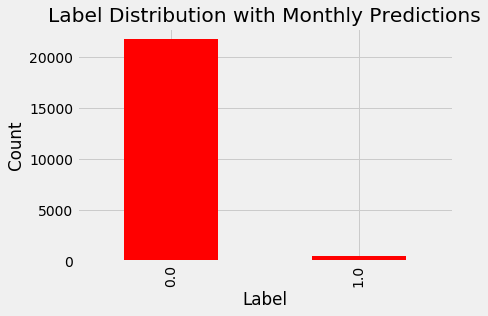

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('fivethirtyeight')

label_times['label'].value_counts().plot.bar(color = 'r');
plt.xlabel('Label'); plt.ylabel('Count'); plt.title('Label Distribution with Monthly Predictions');

This is an imbalanced classification problem. There are far more instances of customers not churning than of customers churning. This is not necessarily an issue as long as we are smart about the choices of metrics we use for modeling. 


## Second Prediction Problem

To demonstrate how to quickly change the problem parameters, we can use the labeling function for a different prediction problem. The parameters are defined below:

* Bimonthly churn
    * Prediction date = first and fifteenth of month
    * Number of days to churn = 14
    * Lead time = 2 weeks
    * Prediction window = 2 weeks

In [15]:
label_times = make_label_times(trans, prediction_date = 'SMS', churn_days = 14,
                               lead_time = 1, prediction_window = 1)
label_times.tail(10)

,msno,cutoff_time,label,days_to_churn,churn_date
45,zzm2UvJnzuTRkXaiaZHtbJwPG9jZQZkZxG0n4PYDTvw=,2016-11-15,0.0,NaN,NaT
46,zzm2UvJnzuTRkXaiaZHtbJwPG9jZQZkZxG0n4PYDTvw=,2016-12-01,0.0,NaN,NaT
47,zzm2UvJnzuTRkXaiaZHtbJwPG9jZQZkZxG0n4PYDTvw=,2016-12-15,0.0,NaN,NaT
48,zzm2UvJnzuTRkXaiaZHtbJwPG9jZQZkZxG0n4PYDTvw=,2017-01-01,0.0,NaN,NaT
49,zzm2UvJnzuTRkXaiaZHtbJwPG9jZQZkZxG0n4PYDTvw=,2017-01-15,0.0,NaN,NaT
50,zzm2UvJnzuTRkXaiaZHtbJwPG9jZQZkZxG0n4PYDTvw=,2017-02-01,0.0,NaN,NaT
51,zzm2UvJnzuTRkXaiaZHtbJwPG9jZQZkZxG0n4PYDTvw=,2017-02-15,0.0,NaN,NaT
52,zzm2UvJnzuTRkXaiaZHtbJwPG9jZQZkZxG0n4PYDTvw=,2017-03-01,0.0,NaN,NaT
53,zzm2UvJnzuTRkXaiaZHtbJwPG9jZQZkZxG0n4PYDTvw=,2017-03-15,NaN,NaN,NaT
54,zzm2UvJnzuTRkXaiaZHtbJwPG9jZQZkZxG0n4PYDTvw=,2017-04-01,NaN,NaN,NaT


In [16]:
label_times.shape

(54527, 5)

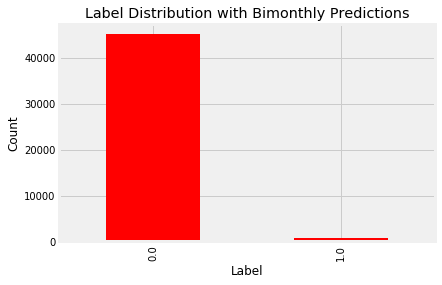

In [17]:
label_times['label'].value_counts().plot.bar(color = 'r');
plt.xlabel('Label'); plt.ylabel('Count'); plt.title('Label Distribution with Bimonthly Predictions');

In [18]:
label_times['label'].isnull().sum()

8525

There are quite a few missing labels, which occur when there is no next transaction for the customer (we don't know if the last entry for the customer is a churn or not). We won't be able to use these examples when training a model although we can make predictions for them.

# Parallelizing Labeling

Now that we have a function that can make a label times table out of customer transactions, we need to label all of the customer transactions in our dataset. We already broke the data into 1000 partitions, so we can parallelize this operation using Spark with PySpark. The basic idea is to write a function that makes the label times for one partition, and then run this in parallel across all the partitions using either multiple cores on a single machine, or a cluster of machines. 

The function below takes in a partition number, reads the transactions data from S3, creates the label times table for both prediction problems, and writes the label times back to S3. We can run this function in parallel over multiple partitions at once since the customers are independent of one another. That is, the labels for one customer do not depend on the data for any other customer. 

In [19]:
def partition_to_labels(partition_number, prediction_dates = ['MS', 'SMS'], churn_periods= [31, 14],
                        lead_times = [1, 1], prediction_windows = [1, 1]):
    """Make labels for all customers in one partition
    Either for one month or twice a month
    
    Params
    --------
        partition (int): number of partition
        label_type (list of str): either 'MS' for monthly labels or
                                  'SMS' for bimonthly labels
        churn_periods(list of int): number of days with no active membership to be considered a churn
        lead_times (list of int): lead times in number of periods
        prediction_windows (list of int): prediction windows in number of periods
    
    Returns
    --------
        None: saves the label dataframes with the appropriate name to the partition directory
    """
    partition_dir = BASE_DIR + 'p' + str(partition_number)
    
    # Read in data and filter anomalies
    trans = pd.read_csv(f'{partition_dir}/transactions.csv',
                        parse_dates=['transaction_date', 'membership_expire_date'], 
                        infer_datetime_format = True)
    
    # Deal with data inconsistencies
    rev = trans[(trans['membership_expire_date'] < trans['transaction_date']) | 
            ((trans['is_cancel'] == 0) & (trans['membership_expire_date'] == trans['transaction_date']))]
    rev_members = rev['msno'].unique()
    
    # Remove data errors
    trans = trans.loc[~trans['msno'].isin(rev_members)]

    # Create both sets of lables
    for prediction_date, churn_days, lead_time, prediction_window in zip(prediction_dates, churn_periods, lead_times, prediction_windows):
        
        cutoff_list = []
            
        # Make label times for all customers
        cutoff_list.append(make_label_times(trans, prediction_date = prediction_date, 
                                            churn_days = churn_days, lead_time = lead_time,
                                            prediction_window = prediction_window))
        # Turn into a dataframe
        cutoff_times = pd.concat(cutoff_list)
        cutoff_times = cutoff_times.drop_duplicates(subset = ['msno', 'cutoff_time'])
        
        # Encode in order to write to s3
        bytes_to_write = cutoff_times.to_csv(None, index = False).encode()

        # Write cutoff times to S3
        with fs.open(f'{partition_dir}/{prediction_date}-{churn_days}_labels.csv', 'wb') as f:
            f.write(bytes_to_write)

In [ ]:
partition_to_labels(1, prediction_dates = ['MS'], churn_periods = [31], 
                    lead_times = [1], prediction_windows = [1])

In [20]:
label_times = pd.read_csv('s3://customer-churn-spark/p1/MS-31_labels.csv')
label_times.tail(10)

,msno,cutoff_time,label,days_to_churn,churn_date
27232,ztr541XHzi0M0EPSrCSUEytFoqKIbZXNiJhszP8vuGw=,2016-10-01,0.0,NaN,NaN
27233,ztr541XHzi0M0EPSrCSUEytFoqKIbZXNiJhszP8vuGw=,2016-11-01,0.0,NaN,NaN
27234,ztr541XHzi0M0EPSrCSUEytFoqKIbZXNiJhszP8vuGw=,2016-12-01,0.0,NaN,NaN
27235,ztr541XHzi0M0EPSrCSUEytFoqKIbZXNiJhszP8vuGw=,2017-01-01,0.0,NaN,NaN
27236,ztr541XHzi0M0EPSrCSUEytFoqKIbZXNiJhszP8vuGw=,2017-02-01,0.0,NaN,NaN
27237,ztr541XHzi0M0EPSrCSUEytFoqKIbZXNiJhszP8vuGw=,2017-03-01,NaN,NaN,NaN
27238,ztr541XHzi0M0EPSrCSUEytFoqKIbZXNiJhszP8vuGw=,2017-04-01,NaN,NaN,NaN
27239,zxHN7E8uhYR9vlOKqRoFetJE03BESH+raGiZ8evjaec=,2017-02-01,0.0,NaN,NaN
27240,zxHN7E8uhYR9vlOKqRoFetJE03BESH+raGiZ8evjaec=,2017-03-01,NaN,NaN,NaN
27241,zxHN7E8uhYR9vlOKqRoFetJE03BESH+raGiZ8evjaec=,2017-04-01,NaN,NaN,NaN


In [ ]:
partition_to_labels(1, prediction_dates = ['SMS'], churn_periods = [14],
                    lead_times = [1], prediction_windows = [1])

In [21]:
label_times = pd.read_csv('s3://customer-churn-spark/p1/SMS-14_labels.csv')
label_times.head(10)

,msno,cutoff_time,label,days_to_churn,churn_date
0,+31Inxq3oTPJqYZz4kLCoBqxMpVuVeh3lZBS5gM/TJU=,2015-01-01,0.0,NaN,NaN
1,+31Inxq3oTPJqYZz4kLCoBqxMpVuVeh3lZBS5gM/TJU=,2015-01-15,0.0,NaN,NaN
2,+31Inxq3oTPJqYZz4kLCoBqxMpVuVeh3lZBS5gM/TJU=,2015-02-01,0.0,NaN,NaN
3,+31Inxq3oTPJqYZz4kLCoBqxMpVuVeh3lZBS5gM/TJU=,2015-02-15,0.0,NaN,NaN
4,+31Inxq3oTPJqYZz4kLCoBqxMpVuVeh3lZBS5gM/TJU=,2015-03-01,0.0,NaN,NaN
5,+31Inxq3oTPJqYZz4kLCoBqxMpVuVeh3lZBS5gM/TJU=,2015-03-15,0.0,NaN,NaN
6,+31Inxq3oTPJqYZz4kLCoBqxMpVuVeh3lZBS5gM/TJU=,2015-04-01,0.0,NaN,NaN
7,+31Inxq3oTPJqYZz4kLCoBqxMpVuVeh3lZBS5gM/TJU=,2015-04-15,0.0,NaN,NaN
8,+31Inxq3oTPJqYZz4kLCoBqxMpVuVeh3lZBS5gM/TJU=,2015-05-01,0.0,NaN,NaN
9,+31Inxq3oTPJqYZz4kLCoBqxMpVuVeh3lZBS5gM/TJU=,2015-05-15,0.0,NaN,NaN


## Spark for Parallelization

The below code uses Spark to parallelize the label making. This particular implementation uses a single machine although the same idea can be extended to a cluster of machines.

In [ ]:
# Update accordingly based on your Spark setup
import findspark
findspark.init('/usr/local/spark/')

import pyspark

conf = pyspark.SparkConf()

# Enable logging
conf.set('spark.eventLog.enabled', True);
conf.set('spark.eventLog.dir', '/data/churn/tmp/');

# Use all cores on a single machine
conf.set('spark.num.executors', 1)
conf.set('spark.executor.memory', '56g')
conf.set('spark.executor.cores', 15)

# Make sure to specify correct spark master ip
sc = pyspark.SparkContext(master = 'spark://ip-172-31-23-133.ec2.internal:7077',
                          appName = 'labeling', conf = conf)

sc

In [ ]:
from timeit import default_timer as timer

# Parallelize making all labels in Spark
start = timer()
sc.parallelize(list(range(1000)), numSlices=1000).\
   map(partition_to_labels).collect()
sc.stop()
end = timer()

While Spark is running, you can navigate to localhost:4040 to see the details of the particular job, or to localhost:8080 to see the overview of the cluster. This is useful for diagnosing the state of a spark operation.

In [ ]:
print(f'{round(end - start)} seconds elapsed.')

In [22]:
labels = pd.read_csv(f's3://customer-churn-spark/p980/MS-31_labels.csv')
labels.tail(10)

,msno,cutoff_time,label,days_to_churn,churn_date
26593,zuh7jGXSTQLrwHOgh9DDt2FmmsUXszvivNIF3RLSZck=,2016-07-01,0.0,NaN,NaN
26594,zuh7jGXSTQLrwHOgh9DDt2FmmsUXszvivNIF3RLSZck=,2016-08-01,0.0,NaN,NaN
26595,zuh7jGXSTQLrwHOgh9DDt2FmmsUXszvivNIF3RLSZck=,2016-09-01,0.0,NaN,NaN
26596,zuh7jGXSTQLrwHOgh9DDt2FmmsUXszvivNIF3RLSZck=,2016-10-01,0.0,NaN,NaN
26597,zuh7jGXSTQLrwHOgh9DDt2FmmsUXszvivNIF3RLSZck=,2016-11-01,0.0,NaN,NaN
26598,zuh7jGXSTQLrwHOgh9DDt2FmmsUXszvivNIF3RLSZck=,2016-12-01,0.0,NaN,NaN
26599,zuh7jGXSTQLrwHOgh9DDt2FmmsUXszvivNIF3RLSZck=,2017-01-01,0.0,NaN,NaN
26600,zuh7jGXSTQLrwHOgh9DDt2FmmsUXszvivNIF3RLSZck=,2017-02-01,0.0,NaN,NaN
26601,zuh7jGXSTQLrwHOgh9DDt2FmmsUXszvivNIF3RLSZck=,2017-03-01,NaN,NaN,NaN
26602,zuh7jGXSTQLrwHOgh9DDt2FmmsUXszvivNIF3RLSZck=,2017-04-01,NaN,NaN,NaN


In [23]:
labels = pd.read_csv(f's3://customer-churn-spark/p980/SMS-14_labels.csv')
labels.tail(10)

,msno,cutoff_time,label,days_to_churn,churn_date
50916,zuh7jGXSTQLrwHOgh9DDt2FmmsUXszvivNIF3RLSZck=,2016-11-15,0.0,NaN,NaN
50917,zuh7jGXSTQLrwHOgh9DDt2FmmsUXszvivNIF3RLSZck=,2016-12-01,0.0,NaN,NaN
50918,zuh7jGXSTQLrwHOgh9DDt2FmmsUXszvivNIF3RLSZck=,2016-12-15,0.0,NaN,NaN
50919,zuh7jGXSTQLrwHOgh9DDt2FmmsUXszvivNIF3RLSZck=,2017-01-01,0.0,NaN,NaN
50920,zuh7jGXSTQLrwHOgh9DDt2FmmsUXszvivNIF3RLSZck=,2017-01-15,0.0,NaN,NaN
50921,zuh7jGXSTQLrwHOgh9DDt2FmmsUXszvivNIF3RLSZck=,2017-02-01,0.0,NaN,NaN
50922,zuh7jGXSTQLrwHOgh9DDt2FmmsUXszvivNIF3RLSZck=,2017-02-15,0.0,NaN,NaN
50923,zuh7jGXSTQLrwHOgh9DDt2FmmsUXszvivNIF3RLSZck=,2017-03-01,0.0,NaN,NaN
50924,zuh7jGXSTQLrwHOgh9DDt2FmmsUXszvivNIF3RLSZck=,2017-03-15,NaN,NaN,NaN
50925,zuh7jGXSTQLrwHOgh9DDt2FmmsUXszvivNIF3RLSZck=,2017-04-01,NaN,NaN,NaN


# Conclusions

In this notebook, we implemented prediction engineering for the customer churn use case. After defining the business need, we translated it into a task that can be solved with machine learning and created a set of label times. We saw how to define functions with parameters so we could solve multiple prediction problems without needing to re-write the entire code. Although we only worked through two problems, there are numerous others that could be solved with the same data and approach.


The label times contain cutoff times for a specific prediction problem along with the associated label. The label times can now be used to make features for each label by filtering the data to before the cutoff time. This ensures that any features made are valid and will automatically be taken care of in Featuretools. 

The general procedure for making labels is:

1. Define the business requirement: predict customers who will churn during a specified period of time
2. Translate the business requirement into a machine learning problem: given historical customer data, build a model to predict which customers will churn depending on several parameters
3. Make labels along with cutoff times corresponding to the machine learning problem: develop functions that take in parameters so the same function can be used for multiple prediction problems.
4. Label all past historical data: parallelize operations by partitioning data into independent subsets

This approach can be extended to other problems. Although the exact syntax is specific to this use case, the overall approach is designed to be general purpose.

## Next Steps

With a complete set of label times, we can now make features for each label using the cutoff times to ensure our features are valid. However, instead of the painstaking and error-prone process of making features by hand, we can use automated feature engineering in [Featuretools](https://github.com/Featuretools/featuretools) to automated this process. Featuretools will build hundreds of relevant features using only a few lines of code and will automatically filter the data to ensure that all of our features are valid. The feature engineering pipeline is developed in the `Feature Engineering` notebook.